# Explore results after scraping results website

### User variables


In [1]:
Date = '2019-05' # yyyy-mm

### Modules and functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image

### Load results

Load auction results and data from rdw.

In [3]:
file_name = '../data/drz-data-{}.pkl'.format(Date)
print(file_name)
drz = pd.read_pickle(file_name)
file_name = '../data/rdw-data-{}.pkl'.format(Date)
print(file_name)
rdw = pd.read_pickle(file_name)

# rdw column names
#   NOTE: format changed in April 2019: RDW info is appended to auction results as extra columns in dataframe
if pd.to_datetime(Date, format='%Y-%m') >= pd.to_datetime('2019-04', format='%Y-%m'):
    rdwinfo = [c for c in rdw.columns if c.startswith('rdw_')]

../data/drz-data-2019-05.pkl
../data/rdw-data-2019-05.pkl


# Cheap cars with valid inspection

In [4]:
is_cheap = (
    drz.LotType == "Personenauto"
) & (
    drz.Price<3000
) & (
    drz.Price>0
) & ~(
    (
        drz.APKdate.isnull()
    ) | (
        drz.APKdate.apply(lambda x:x == '')
    )
)

drz.loc[is_cheap,
        ["Price","ItemType","ItemBrand","Mfdate","APKdate","OdoKM"]].sort_values(by='OdoKM')

,Price,ItemType,ItemBrand,Mfdate,APKdate,OdoKM
2019-5-8112,755.0,fiat panda; 1.1,FIAT,01.02.2006,15.09.2019,128.122
2019-5-8209,588.0,micra; 1.3 3hb,NISSAN,02.01.2001,19.01.2020,138.686
2019-5-8113,808.0,alfa romeo 147; 5 drs. 2.0,ALFA ROMEO,13.05.2002,04.07.2019,155.603
2019-5-8210,2828.0,astra,OPEL,24.06.2008,19.10.2019,161.545
2019-5-8182,2011.0,307; cc 1.6 16v,PEUGEOT,17.06.2005,25.07.2019,169.235
2019-5-8147,2267.0,astra; h-cc z14xep,OPEL,07.03.2005,18.09.2019,171.036
2019-5-8157,452.0,fabia; 50 kw,SKODA,08.01.2003,14.05.2019,175.937
2019-5-8106,1617.0,astra station wagon; h z16xep,OPEL,20.03.2006,13.06.2019,180.580
2019-5-8207,2008.0,swift,SUZUKI,04.04.2007,30.06.2019,180.851
2019-5-8109,2211.0,v50,VOLVO,03.07.2007,03.07.2019,192.106


In [5]:
if pd.to_datetime(Date, format='%Y-%m') < pd.to_datetime('2019-04', format='%Y-%m'):
    display(rdw.loc[is_cheap,["rdwinfo"]])
else:
    display(rdw.loc[is_cheap,rdwinfo])

,rdw_kenteken,rdw_Reg,rdw_aanhangwagen_autonoom_geremd,rdw_aanhangwagen_middenas_geremd,rdw_aantal_cilinders,rdw_aantal_deuren,rdw_aantal_rolstoelplaatsen,rdw_aantal_wielen,rdw_aantal_zitplaatsen,rdw_afstand_hart_koppeling_tot_achterzijde_voertuig,...,rdw_brandstof_uitstoot_deeltjes_licht_1,rdw_brandstof_uitstoot_deeltjes_licht_2,rdw_brandstof_uitstoot_deeltjes_zwaar_1,rdw_brandstof_uitstoot_deeltjes_zwaar_2,rdw_carrosserie_carrosserietype_1,rdw_carrosserie_type_carrosserie_europese_omschrijving_1,rdw_carrosserie_specifiek_carrosserie_voertuig_nummer_code_volgnummer_1,rdw_carrosserie_specifiek_carrosserie_voertuig_nummer_europese_omschrijving_1,rdw_carrosserie_specifiek_carrosseriecode_1,rdw_TimeStamp
2019-5-8103,76PGND,76-PG-ND,NaN,NaN,4.0,4.0,0.0,4.0,7.0,0.0,...,0.03500,NaN,NaN,NaN,AF,MPV,NaN,NaN,NaN,20190511
2019-5-8104,49JPHH,49-JP-HH,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,0.03600,NaN,NaN,NaN,AA,Sedan,NaN,NaN,NaN,20190511
2019-5-8106,66SNSV,66-SN-SV,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,NaN,NaN,NaN,NaN,AC,Stationwagen,NaN,NaN,NaN,20190511
2019-5-8109,RG341S,RG-341-S,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,0.00200,NaN,NaN,NaN,AC,Stationwagen,NaN,NaN,NaN,20190511
2019-5-8112,42SJZX,42-SJ-ZX,NaN,NaN,4.0,4.0,0.0,4.0,4.0,0.0,...,NaN,NaN,NaN,NaN,AB,Hatchback,NaN,NaN,NaN,20190511
2019-5-8113,47JKJP,47-JK-JP,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,NaN,NaN,NaN,NaN,AB,Hatchback,NaN,NaN,NaN,20190511
2019-5-8122,KF298G,KF-298-G,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,0.02200,NaN,NaN,NaN,AF,MPV,NaN,NaN,NaN,20190511
2019-5-8125,80PBFF,80-PB-FF,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,NaN,NaN,NaN,NaN,AB,Hatchback,NaN,NaN,NaN,20190511
2019-5-8127,79TKJ5,79-TKJ-5,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,0.00163,NaN,NaN,NaN,AB,Hatchback,NaN,NaN,NaN,20190511
2019-5-8128,39JHPK,39-JH-PK,NaN,NaN,4.0,4.0,0.0,4.0,5.0,0.0,...,NaN,NaN,NaN,NaN,AB,Hatchback,NaN,NaN,NaN,20190511


In [6]:
if pd.to_datetime(Date, format='%Y-%m') < pd.to_datetime('2019-04', format='%Y-%m'):
    display(rdw.loc[is_cheap,"rdwinfo"][0])
else:
    display(rdw.loc[is_cheap,rdwinfo].iloc[0,:])

rdw_kenteken                                                                                                              76PGND
rdw_Reg                                                                                                                 76-PG-ND
rdw_aanhangwagen_autonoom_geremd                                                                                             NaN
rdw_aanhangwagen_middenas_geremd                                                                                             NaN
rdw_aantal_cilinders                                                                                                           4
rdw_aantal_deuren                                                                                                              4
rdw_aantal_rolstoelplaatsen                                                                                                    0
rdw_aantal_wielen                                                                                

In [7]:
if pd.to_datetime(Date, format='%Y-%m') < pd.to_datetime('2019-04', format='%Y-%m'):
    display(pd.DataFrame(rdw.loc[is_cheap,"rdwinfo"][0]).T)

# Pictures of lots

In [8]:
# ix=drz.N_images.idxmax()
ix=drz.Price.idxmax(); print('Price: EUR {:g}\n\n'.format(drz.loc[ix,'Price']))
# Mfdate = drz.Mfdate.apply(lambda x: pd.to_datetime(x,format='%d.%m.%Y') if len(x)==10 else pd.np.NaN)
# ix=Mfdate.idxmin(); print('year of mf: {:s}\n\n'.format(drz.loc[ix,'Mfdate']))
# ix = '2019-2-2005' # largest km/day
# ix = '2019-2-7345' # largest km

print(ix)
for u in drz.loc[ix,'Images']:
    print(u)
    print(drz.loc[ix,'Source'])
    display(Image(url=u,width=400))
    

Price: EUR 62610


2019-5-2405
http://www.domeinenrz.nl/ufc/static/1556617765/thumb/domeinenrz_sites/6a641104cbeaf20dbb2c723fb196b3a7/1024/768/image.jpg
http://www.domeinenrz.nl/catalogi/verkoop_bij_inschrijving_2019-0005?=&veilingen=2019-0005&meerfotos=K1900052405


http://www.domeinenrz.nl/ufc/static/1556617775/thumb/domeinenrz_sites/f65583ef150aad64548169cd898badbc/1024/768/image.jpg
http://www.domeinenrz.nl/catalogi/verkoop_bij_inschrijving_2019-0005?=&veilingen=2019-0005&meerfotos=K1900052405


http://www.domeinenrz.nl/ufc/static/1556617769/thumb/domeinenrz_sites/a098ccf63dc819e8c3600803b42002f8/1024/768/image.jpg
http://www.domeinenrz.nl/catalogi/verkoop_bij_inschrijving_2019-0005?=&veilingen=2019-0005&meerfotos=K1900052405


# Usage

How many km are driven per year or day?

### Odometer conversion

In [9]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [10]:
odo_str2float(drz)

drz[['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2019-5-1800,13124.20032,nan,NaN,8.155,8155.0
2019-5-1801,11367.00000,11.367,11367.0,nan,NaN
2019-5-1802,53216.00000,53.216,53216.0,nan,NaN
2019-5-1803,10617.00000,10.617,10617.0,nan,NaN
2019-5-1804,8742.00000,8.742,8742.0,nan,NaN
2019-5-1805,19286.00000,19.286,19286.0,nan,NaN
2019-5-1806,44411.00000,44.411,44411.0,nan,NaN
2019-5-1807,8643.00000,8.643,8643.0,nan,NaN
2019-5-1808,12082.00000,12.082,12082.0,nan,NaN
2019-5-1809,8050.00000,8.050,8050.0,nan,NaN


### Dates

In [11]:
AuctDate = pd.to_datetime(drz.index[0][0:-5], format = '%Y-%m')

# serial date
drz["Mfdate_ser"] = drz.Mfdate.apply(lambda x:pd.to_datetime(x, format = '%d.%m.%Y') if (x!='') & ('-' not in x) else pd.np.NaN)

# age
drz["Age"] = (AuctDate - drz.Mfdate_ser)
drz["Age_year"] = drz.Age.apply(lambda x:x.days/365.25)

- - - -
# Continue with cars only

In [12]:
out = drz.Price.copy()
Features = drz.loc[:,["ItemBrand","ItemType","Odo","Age_year"]].copy()

In [13]:
# Drop rows
Subsel = drz.LotType == 'Personenauto'
dropIx=drz[~Subsel].index
out.drop(index=dropIx,inplace=True)
Features.drop(index=dropIx,inplace=True)

### one hot encoding brand and model

In [14]:
Dummies = pd.get_dummies(Features.ItemBrand,prefix='Brand_',drop_first=False)
Features = pd.concat([Features,Dummies],axis=1)

Features.describe()

,Odo,Age_year,Brand__ALFA ROMEO,Brand__AUDI,Brand__BMW,Brand__CHEVROLET,Brand__CITROËN,Brand__DAEWOO,Brand__FIAT,Brand__FORD,...,Brand__QUATTRO,Brand__RENAULT,Brand__ROLLS ROYCE,Brand__ROVER,Brand__SEAT,Brand__SKODA,Brand__SUZUKI,Brand__TOYOTA,Brand__VOLKSWAGEN,Brand__VOLVO
count,154.000000,156.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,...,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,205254.584361,12.089998,0.018987,0.094937,0.069620,0.018987,0.044304,0.006329,0.056962,0.006329,...,0.006329,0.031646,0.006329,0.006329,0.044304,0.006329,0.012658,0.006329,0.145570,0.056962
std,93293.414650,5.397435,0.136914,0.294060,0.255315,0.136914,0.206423,0.079556,0.232507,0.079556,...,0.079556,0.175611,0.079556,0.079556,0.206423,0.079556,0.112150,0.079556,0.353796,0.232507
min,25128.000000,2.543463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,138942.250000,8.136893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,196400.000000,11.861739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,268136.500000,15.331280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,485254.000000,40.654346,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Plotting

In [15]:
def ecdf(data):
    x = sorted(data)
    y = pd.np.arange(0,len(x))/len(x)
    return x,y

# # example
# x,y = ecdf(km_p_day)
# plt.plot(x,y)

In [16]:
# km per day
km_p_day = Features.Odo/(Features.Age_year*365.25).fillna(0)
sel = ~(km_p_day.isna() | (km_p_day == pd.np.inf))
km_p_day = km_p_day.loc[sel]

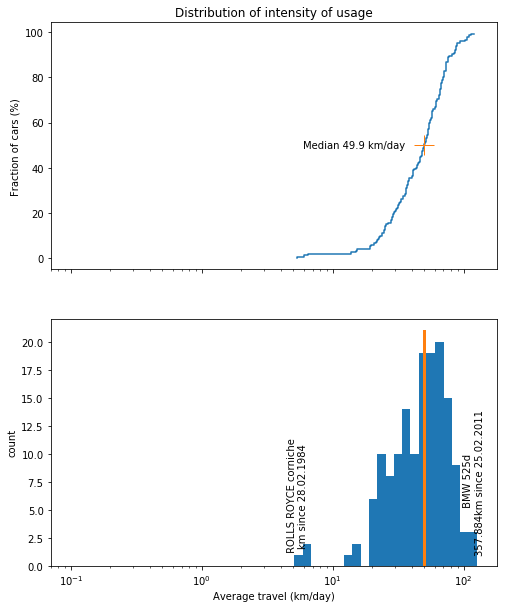

In [17]:
# Plot ecdf and hist
x,y = ecdf(km_p_day)
fig,axs = plt.subplots(ncols=1,nrows=2, figsize=[8,10],sharex=True)

# ecdf
ax = axs[0]
ax.step(x,y*100)
ax.plot(pd.np.median(x),50,'+',markersize=20)
ax.text(pd.np.median(x),50,'Median {:.1f} km/day      '.format(pd.np.median(x)),ha='right',va='center');
ax.set_title('Distribution of intensity of usage')
ax.set_ylabel('Fraction of cars (%)')

xl = axs[0].get_xlim()

# hist
ax = axs[1]
ax.hist(x,bins=pd.np.logspace(-1,pd.np.log10(xl[1]),50))
yl = axs[1].get_ylim()
ax.plot(pd.np.array([1,1])*pd.np.median(x),yl,'-',linewidth=3)
ax.set_xlabel('Average travel (km/day)')
ax.set_ylabel('count')

ax.text(
    km_p_day.min(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmin(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.text(
    km_p_day.max(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmax(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.set_xscale('log')


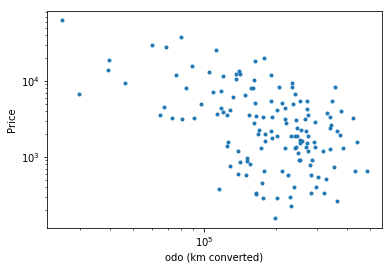

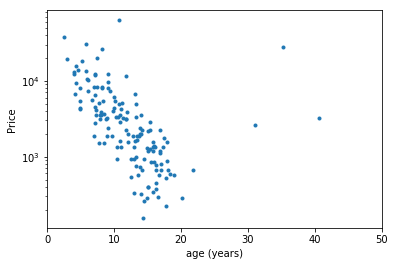

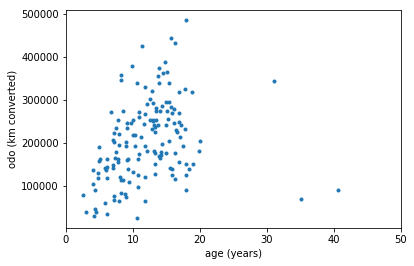

In [18]:
plt.plot(Features.Odo,out,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('odo (km converted)')
plt.ylabel('Price')

plt.figure()
plt.plot(Features.Age_year,out,'.')
plt.yscale('log')
plt.xlabel('age (years)')
plt.ylabel('Price')
plt.xlim(0,50)


plt.figure()
plt.plot(Features.Age_year,Features.Odo,'.')
plt.xlabel('age (years)')
plt.ylabel('odo (km converted)')
plt.xlim(0,50)

plt.show()



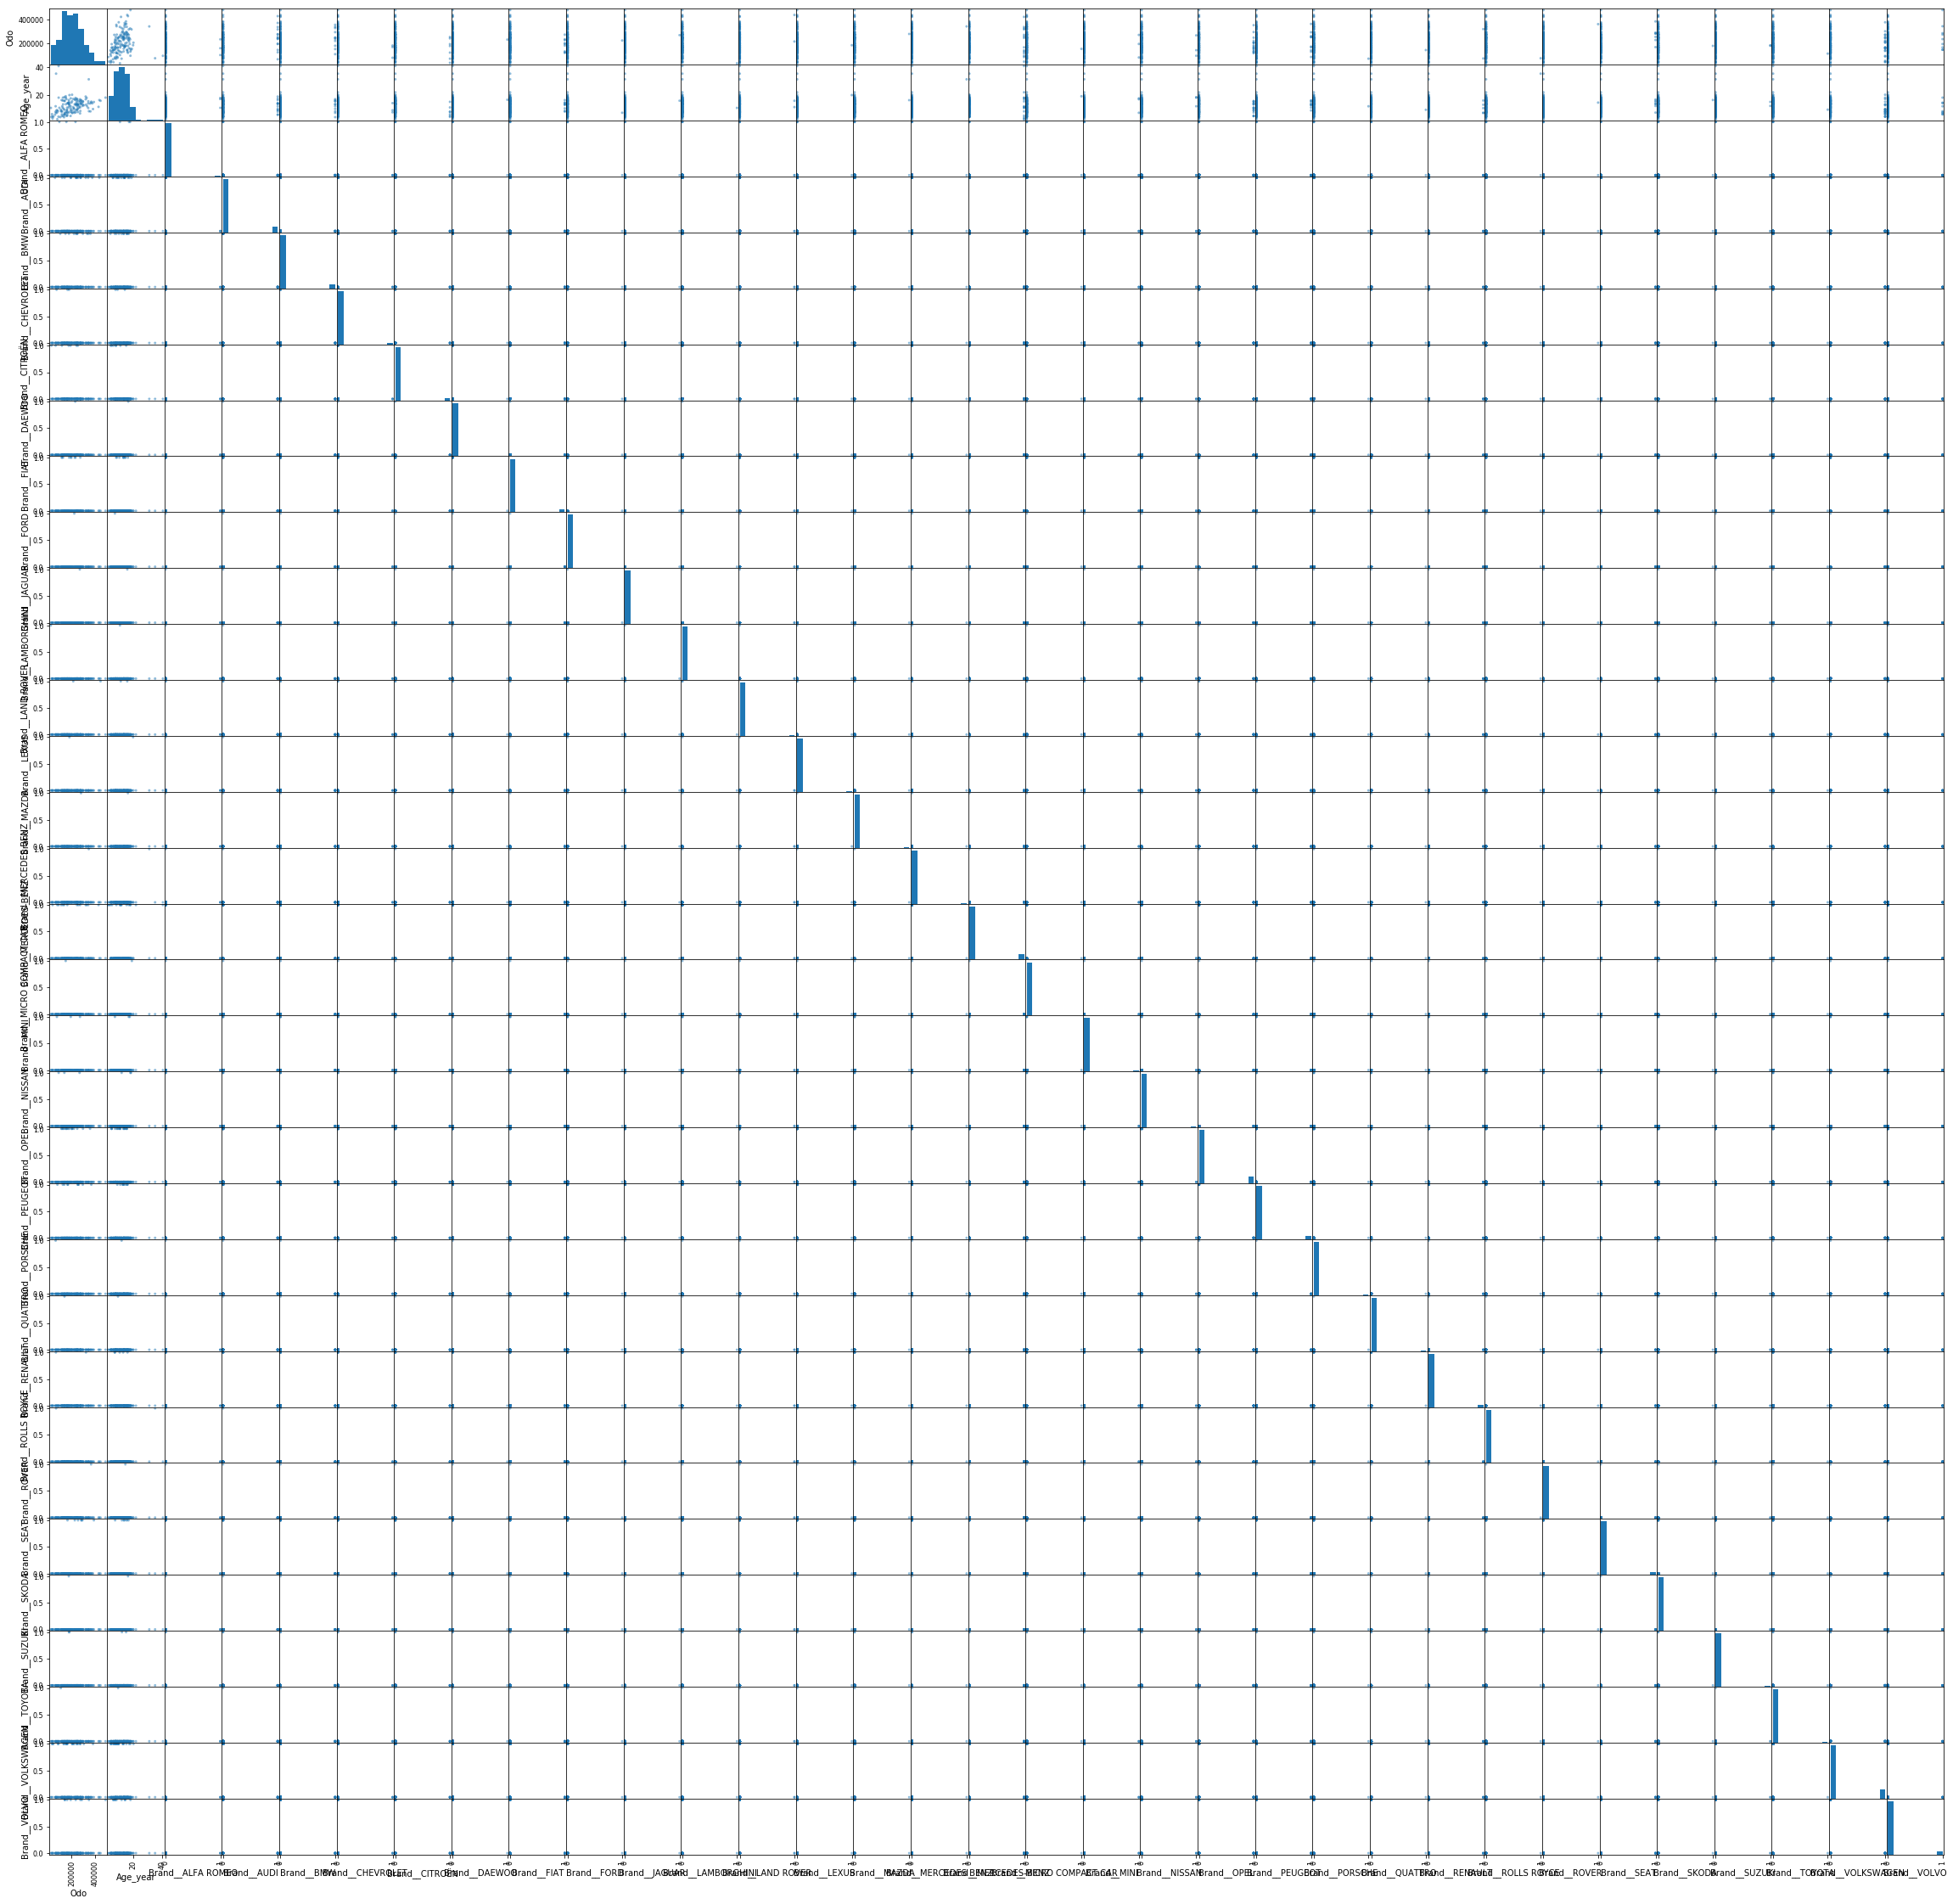

In [19]:
pd.plotting.scatter_matrix(Features,figsize=[40,40])
plt.show()